# FasterR-CNN Inference

In this notebook we run the inference procedure through FasterR-CNN. The first 3 sections deal with the import of the data. The last one on inference.

## Table of contents
1. [Dataframes import](#df)
2. [Dataset import](#dataset)
3. [Dataloaders](#datal)<br>
    3.1 [Colored images](#col_img)<br>
    3.2 [BW images](#bw_img)<br>
4. [Inference](#inf)<br>
    4.1 [Base Model](#aug_m)<br>
    4.2 [BW Model](#bw_m)<br>
    4.3 [Undersampled Model](#under_m)<br>
    4.4 [Oversampled Model](#over_m)<br>
    4.5 [Predicting BW with Base Model](#bestVSbw)

In [1]:
# importing libraries
import pandas as pd
import json
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sn
import numpy as np
from PIL import Image
import torchvision
from typing_extensions import Concatenate
from torch.utils.data.sampler import Sampler
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import albumentations.pytorch
import albumentations
import cv2
import time
import torch
import pickle
from tqdm.notebook import tqdm

## FasterR-CNN Model and Device

In [2]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")  
    
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


## 1. Importing Dataframes <a class="anchor" id="df"></a>
We import the validation and test dataframes preprocessed in the ```Preprocessing.ipynb``` notebook in order to have seperate dataframes for validation and test set, with the respective ```catgory_id```, ```identifier```.  

In [3]:
# importing the validation dataframe
file = open("pickles/val.pickle", "rb")
val_df_final = pickle.load(file)
file.close()

# importing the test dataframe
file = open("pickles/test.pickle", "rb")
test_df_final = pickle.load(file)
file.close()

In [4]:
# encoding category to integers
encode_cat_dic = {'Ardea alba': 1,
 'Melospiza melodia': 2,
 'Buteo jamaicensis': 3,
 'Pandion haliaetus': 4,
 'Junco hyemalis': 5,
 'Zenaida macroura': 6,
 'Cardinalis cardinalis': 7,
 'Picoides pubescens': 8,
 'Agelaius phoeniceus': 9,
 'Ardea herodias': 10,
 'Background':11}

In [5]:
enc2cat = {v:k for k,v in encode_cat_dic.items()}

## 2. Dataset Class <a class="anchor" id="datatset"></a>
We import here all the functions and classes contained in the ```dataset.py``` file.
Here below a brief explanation of the classes we have implemented:
- ```AvesAugmentationDataset```: customized dataset class that satisfied our needs for the augmentations we will performe.
- ```AvesStochAugDataset```: customized dataset class needed for the dataset we will use for the under-sampled and over-sampled models.
- ```SATMsampler```: customized sampler class for obtaining balanced class in the sampler.

In [6]:
from SATM.dataset import AvesAugmentationDataset, SATMsampler
from SATM.dataset import collate_fn, generate_box, generate_target, plot_image_from_output

## 3. Dataloaders <a class="anchor" id="datal"></a>

### 3.1 Dataloader - Colored images <a class="anchor" id="col_img"></a>
To create the dataloader for the colored images, we used the ```AvesAugmentationDataset``` class with ```num_aug```=1. Then we use this dataset to create a dataloader for the dev and test sets, with a batch size of 2 for computational reasons.

In [7]:
path__= "data/images"

In [8]:
# defining the dataset class  and data loader for the dev 
dev_augAves = AvesAugmentationDataset(path__ +'/Val', transform=None, df=val_df_final,num_aug=1)
dev_data_loader = torch.utils.data.DataLoader(dev_augAves, batch_size=2, collate_fn=collate_fn)

# defining the dataset class  and data loader for the test 
test_augAves = AvesAugmentationDataset(path__ +'/Test', transform=None, df=test_df_final,num_aug=1)
test_data_loader = torch.utils.data.DataLoader(test_augAves, batch_size=2, collate_fn=collate_fn)

### 3.2 Dataloader - BW images <a class="anchor" id="bw_img"></a>
Again, we used the ```AvesAugmentationDataset``` class to create the dataloader for the Black and White model. This time, the images given to the dataloader are black and white, located in the appropriate folder.

In [9]:
path_bw = "data_bw/images"

In [10]:
# BW dev
dev_augAves_bw = AvesAugmentationDataset(path_bw +'/Val', transform=None, df=val_df_final,num_aug=1)
dev_data_loader_bw = torch.utils.data.DataLoader(dev_augAves_bw, batch_size=2, collate_fn=collate_fn)

# BW test
test_augAves_bw = AvesAugmentationDataset(path_bw +'/Test', transform=None, df=test_df_final,num_aug=1)
test_data_loader_bw = torch.utils.data.DataLoader(test_augAves_bw, batch_size=2, collate_fn=collate_fn)

## 4. FasterRCNN inference <a class="anchor" id="inf"></a>

Let's start the inference procedure. This will be structured by analyzing different metrics:
- mAP: we check its evolution across epochs paying particular attention to the last one.
- mPrecision: mean precision across epochs.
- mRecall: mean recall across epochs.
- mF1: mean F1 across epochs.

Al these metrics are "global", meaning that they capture the general behaviour of the models. However, we wanted also a metric that enables us to investigate more in depth each class. For this reason we us a Confusion Matrix. To do so, we created from zero a function which is similar to the one implement in YOLO. The confusion must be read by columns, meaning that if we pick one class among the true ones, proceeding by column we get insight about how each bird belonging to that species is classified, i.e. the recall for each class. Moreover, it is important to notice that we have 10 classes, so the random chance is 10$\%$. This means that having a recall for each class around $30\%$ or more is yet a good result.


In [11]:
# importing function from inference.py
from SATM.inference import make_prediction, get_batch_statistics, bbox_iou, ap_per_class, compute_ap, \
                            create_confusion_matrix, epoch_eval, plot_epoch_eval, pred_cm,compute_mAP, plot_pred

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


### 4.1 Base Augmented Model <a class="anchor" id="aug_m"></a>

Here we run the base model: training and inference over RGB images.

In [12]:
model_dir = "Model_Faster/Aug"

In [13]:
mPrecisions, mRecalls, mAPs, mF1s = epoch_eval(model_dir,dev_data_loader)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

As we can see in the next plot, three out of four metrics are increases throughout all the epochs. This suggest we could have trained more the model, however since the metrics are yet interesting and also for time concers we diced to stop at 4 epochs.

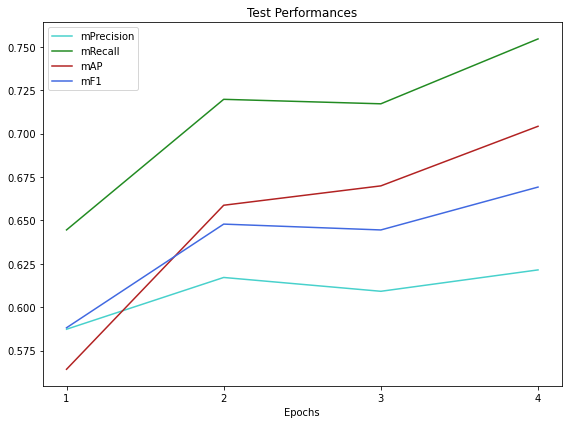

In [14]:
plot_epoch_eval(model_dir, mPrecisions, mRecalls, mAPs, mF1s)

In [15]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

In [16]:
#last epoch's val mAP
last_mAP_base = compute_mAP(dev_data_loader, model, 0.001, 0.5)
print("mAP:",np.round(float(last_mAP_base),3))

  0%|          | 0/1112 [00:00<?, ?it/s]

mAP: 0.763


#### Confusion Matrix

In [17]:
# model prediction to create confusion matrix
dict_ground_truth_base, dict_result_base = pred_cm(model, dev_data_loader)

  0%|          | 0/1112 [00:00<?, ?it/s]

Here above we plotted a random prediction (on the right) with the respectives original image and box.

As we can see in the next confusion matrix, many classes are classified as background, meaning that the model struggles to detect them inside the image. However, once a bird is found, then most of the times the classification is correct.

If we have a look at the last columns, many times there's a detection of not existing birds.

  0%|          | 0/2224 [00:00<?, ?it/s]

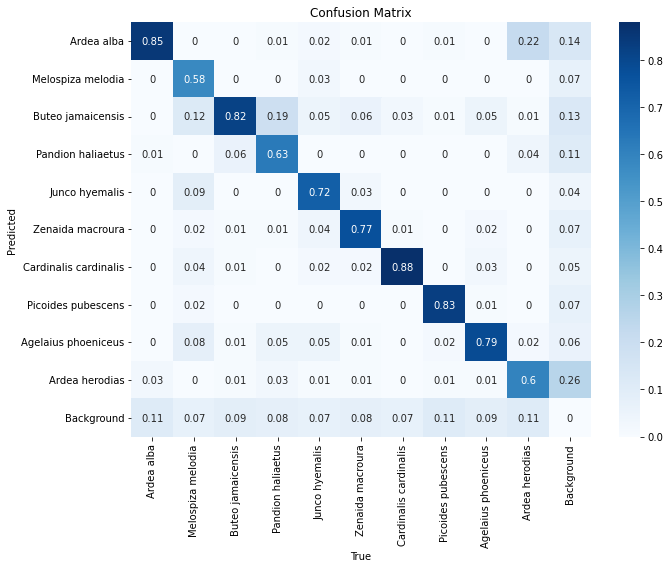

In [18]:
confusion_matrix_aug = create_confusion_matrix(dict_ground_truth_base, dict_result_base, 10)

Target:  Ardea alba
Pred:  Ardea alba


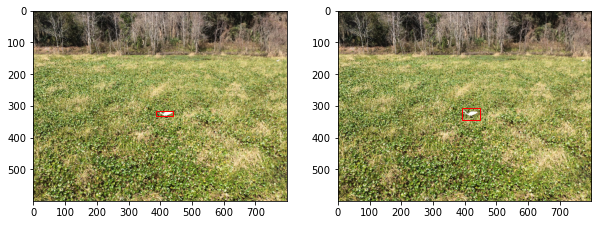

In [24]:
plot_pred(dict_ground_truth_base, dict_result_base)

### 4.2 BW Model <a class="anchor" id="bw_m"></a>

Here we trained the model over Black and White images and now we make inference over BW as well.

In [19]:
model_dir = "Model_Faster/BW"

In [20]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

In [24]:
#last epoch's val mAP
last_mAP_bw = compute_mAP(dev_data_loader_bw, model, 0.001, 0.5)
print("mAP:",np.round(float(last_mAP_bw),3))

  0%|          | 0/1112 [00:00<?, ?it/s]

mAP: 0.668


#### Epochs evaluation

In [25]:
mPrecisions, mRecalls, mAPs, mF1s = epoch_eval(model_dir,dev_data_loader_bw)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

Having a look at the following plot, we see that up to the 4 almost all metrics are increasing. This would suggestto train more the model, however we notice a slight reduction in the steepness of the curves which brought us to stop the training procedre considering also trainin time problems. Avtually, this behaviour is repeated in most of the settings. Proceeding in this notebook we won't comment anymore this graph, expect if we observe a different pattern.

Another interesting result is the reduction in mAP with respect to the previous case. Actually, this is predictable since by removing colors we are reducing the amount of information over which we can train our model. Also, considering our framework, the colors must play an important role.

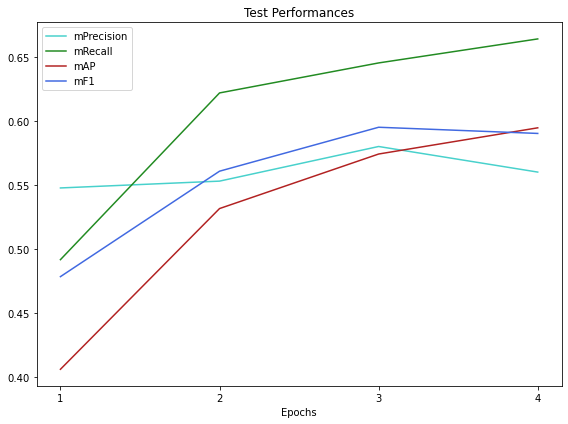

In [26]:
plot_epoch_eval(model_dir, mPrecisions, mRecalls, mAPs, mF1s)

#### Confusion Matrix

In [27]:
# model prediction to create confusion matrix
dict_ground_truth_bw, dict_result_bw = pred_cm(model, dev_data_loader_bw)

  0%|          | 0/1112 [00:00<?, ?it/s]

Going more deeply in the analysis of each class, with respect to the previous case we do not observe a significant increse in classifying true birds as background. However, we notice an almost global reduction in the diagonal, meaning that the model struggles more in distinguishing the different classes. Moreover, some species are confused amomng them (look at the off-diagonal numbers).

  0%|          | 0/2224 [00:00<?, ?it/s]

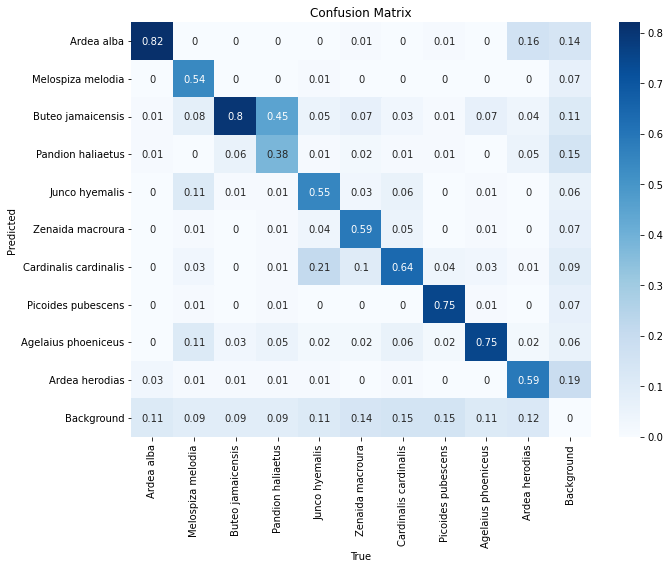

In [28]:
confusion_matrix_BW = create_confusion_matrix(dict_ground_truth_bw, dict_result_bw, 10)

Here above we plotted a random prediction (on the right) with the respectives original image and box.

Target:  Ardea herodias
Pred:  Ardea herodias


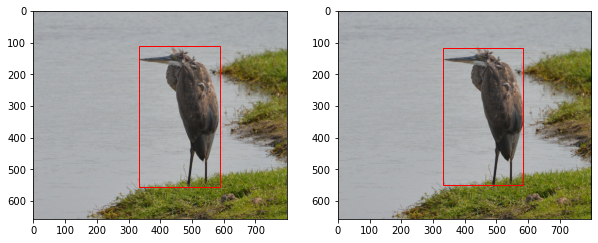

In [29]:
plot_pred(dict_ground_truth_bw, dict_result_bw,'data_bw/images')

### 4.3 Undersampled Model <a class="anchor" id="under_m"></a>

In this section we run the model over an Undersampled set of RGB data.

In [30]:
model_dir = "Model_Faster/Under"

In [31]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

#### Epochs evaluation

In [32]:
mPrecisions, mRecalls, mAPs, mF1s = epoch_eval(model_dir, dev_data_loader)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

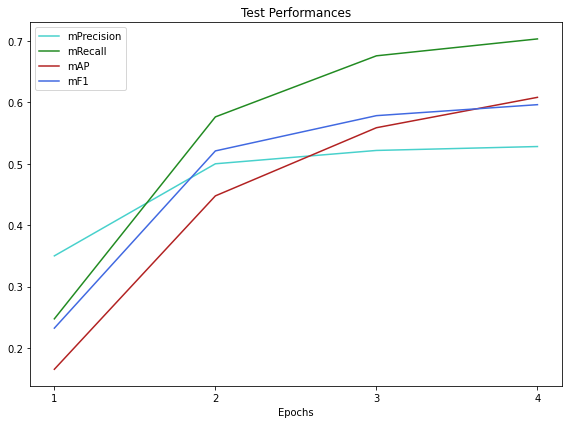

In [33]:
plot_epoch_eval(model_dir, mPrecisions, mRecalls, mAPs, mF1s)

In [34]:
#last epoch's val mAP
last_mAP_und = compute_mAP(dev_data_loader, model, 0.001, 0.5)
print("mAP:",np.round(float(last_mAP_und),3))

  0%|          | 0/1112 [00:00<?, ?it/s]

mAP: 0.668


We notice a reduction in the mAP. This is predictable, since we are reducing the global amount of information by discarding some images and also we are keeping the model fixed, meaning that we have less data to estimate the same number of parameters.

#### Confusion Matrix

In [35]:
# model prediction to create confusion matrix
dict_ground_truth_und, dict_result_und = pred_cm(model, dev_data_loader)

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

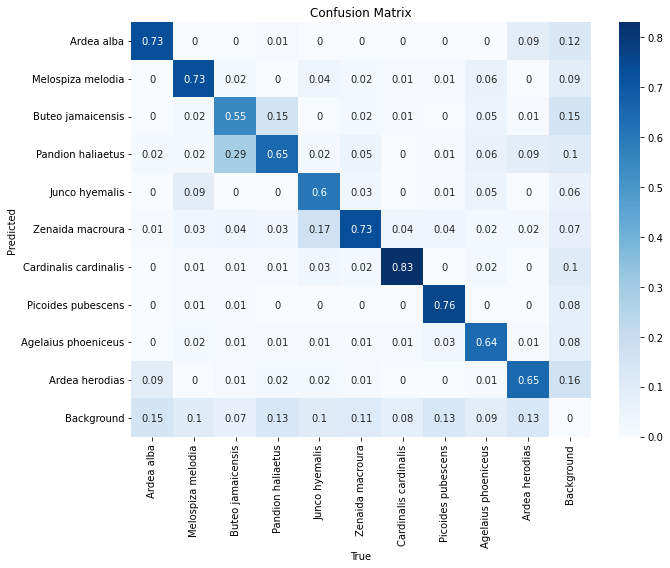

In [36]:
confusion_matrix_under = create_confusion_matrix(dict_ground_truth_und, dict_result_und, 10)

Here above we plotted a random prediction (on the right) with the respectives original image and box.

Target:  Cardinalis cardinalis
Pred:  Cardinalis cardinalis


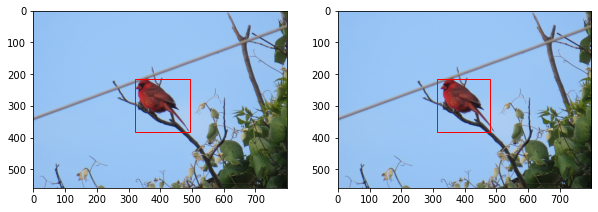

In [39]:
plot_pred(dict_ground_truth_und, dict_result_und)

### 4.4 Oversampled Model <a class="anchor" id="over_m"></a>

In this section we run the model over an Oversampled set of RGB data.

In [40]:
model_dir = "Model_Faster/Over"

In [41]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

#### Epochs evaluation

In [42]:
mPrecisions, mRecalls, mAPs, mF1s = epoch_eval(model_dir, dev_data_loader)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/1112 [00:00<?, ?it/s]

Differently from all the other settings, we observe that the graph is not increasing up to the 4th epoch. Indeed among 3 and 4 we observe a decrease in all metrics. This suggests us to used the model trained on 3 epochs to make inference.

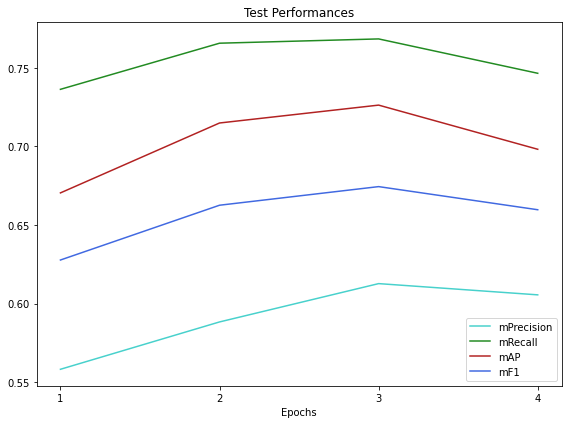

In [43]:
plot_epoch_eval(model_dir, mPrecisions, mRecalls, mAPs, mF1s)

In [44]:
#last epoch's val mAP
last_mAP_ov = compute_mAP(dev_data_loader, model, 0.001, 0.5)
print("mAP:",np.round(float(last_mAP_ov),3))

  0%|          | 0/1112 [00:00<?, ?it/s]

mAP: 0.746


The mAP is slighlty bigger than the first case (BaseAugmented Model), around 0.01 of increase. However, we think this isn't a reasonable increase in the performance considering that we used many more data. An explanation of this behaviour could be found in the Bias-Variance tradeoff. The idea of oversampling is to reduce the bias of underrepresented classes, however by replicating the corresponding images (with some transformation) increases a lot the variance of our model.

#### Confusion Matrix

In [45]:
file = open(f"{model_dir}/model_epoch3.pkl", "rb")
model = pickle.load(file)
file.close()

In [46]:
# model prediction to create confusion matrix
dict_ground_truth_ov, dict_result_ov = pred_cm(model, dev_data_loader)

  0%|          | 0/1112 [00:00<?, ?it/s]

  0%|          | 0/2224 [00:00<?, ?it/s]

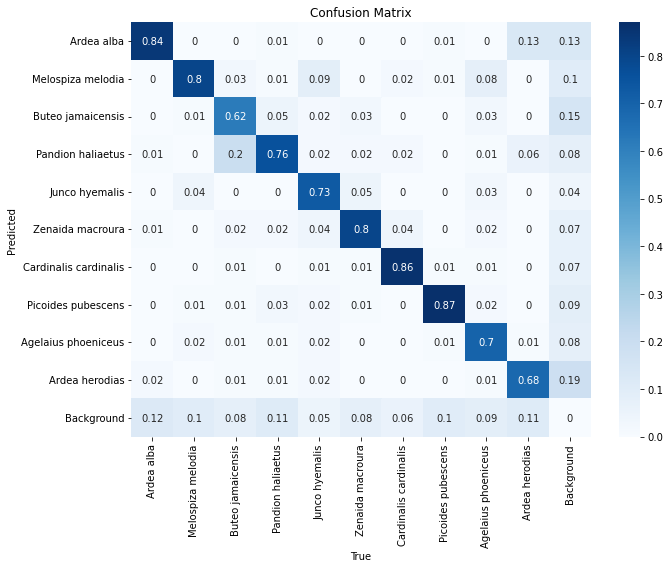

In [47]:
confusion_matrix_over = create_confusion_matrix(dict_ground_truth_ov, dict_result_ov, 10)

Here above we plotted a random prediction (on the right) with the respectives original image and box.

Target:  Buteo jamaicensis
Pred:  Buteo jamaicensis


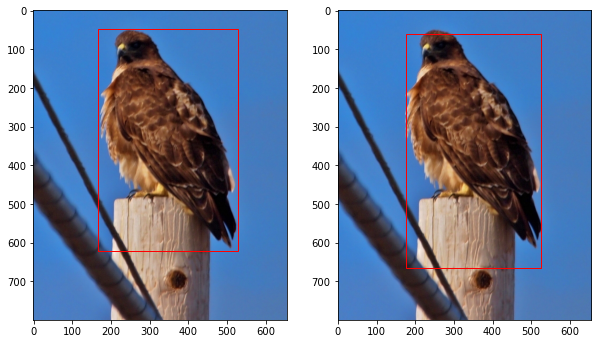

In [71]:
plot_pred(dict_ground_truth_ov, dict_result_ov)

### 4.5 Predicting BW with Base Model <a class="anchor" id="bestVSbw"></a>

Here we tried to predict BW images using a model trained on RGB images. Doing this we can understand if our model is looking only at colors in detecting birds or if it is able to get insights from other features.

In [72]:
model_dir = "Model_Faster/Over"

In [73]:
file = open(f"{model_dir}/model_epoch4.pkl", "rb")
model = pickle.load(file)
file.close()

In [74]:
#last epoch's val mAP
last_mAP_col2bw = compute_mAP(dev_data_loader_bw, model, 0.001, 0.5)
print("mAP:",np.round(float(last_mAP_col2bw),3))

  0%|          | 0/1112 [00:00<?, ?it/s]

mAP: 0.535


Here the result is very interesting, removing the color feature the mAP drops from 0.56 to 0.37. This could suggest the model is concentrating to much just on the colors.

#### Confusion Matrix

In [75]:
# model prediction to create confusion matrix
dict_ground_truth_col2bw, dict_result_col2bw = pred_cm(model, dev_data_loader_bw)

  0%|          | 0/1112 [00:00<?, ?it/s]

The previous result is confirmed by looking at the confusion matrix. Indeed similar classes are higly confused (see Buteo and Pandion) and also Cardinalis, which is characterized by a birght red, is often missclassified.

  0%|          | 0/2224 [00:00<?, ?it/s]

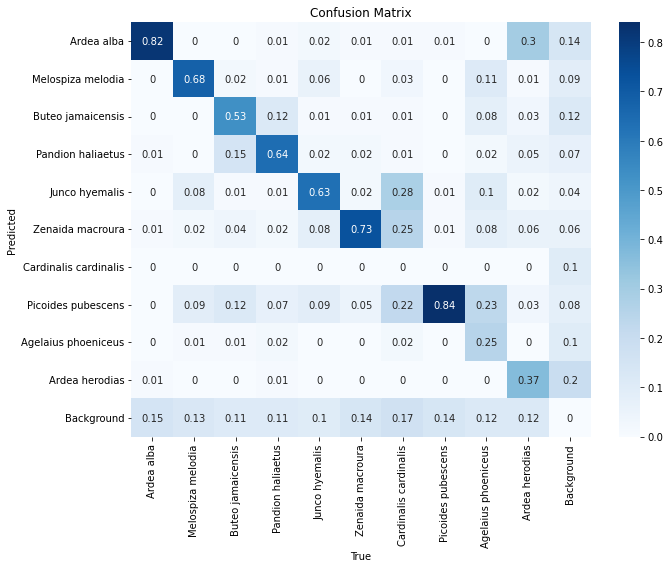

In [76]:
confusion_matrix_col2bw = create_confusion_matrix(dict_ground_truth_col2bw, dict_result_col2bw, 10)

Target:  Cardinalis cardinalis
Pred:  Ardea alba


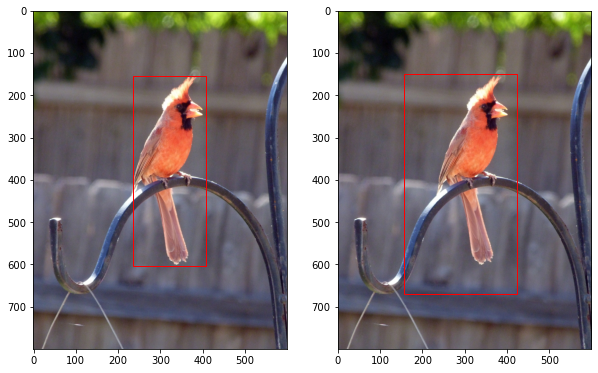

In [77]:
plot_pred(dict_ground_truth_col2bw, dict_result_col2bw)